In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

Newton's law of gravity $F = ma = GMm/r^2$ and hence $a = GM/r^2$. For a collection of masses, written in terms of vector calculus:

$$\frac{d^2 \vec{r}_i}{dt^2} = \sum_{j \neq i} \frac{Gm_j}{r_{ij}^3} \vec{r}_{ij} $$

where $\vec{r}_i$ and $m_i$ is the location and mass of the $ i^{th} $ particle, and $\vec{r}_{ij} = \vec{r}_j - \vec{r}_i$ (the tail of this vector is at $\vec{r}_i$ and points to $\vec{r}_j$).

Dimensions for this problem are gross $G = 6.67 \times 10^{-11}$ too small for efficient computation on computer. Convert to dimensionless quantities:

$$\frac{d^2 \vec{r}_i'}{dt'^2} = \sum_{j \neq i} \frac{m_j'}{r_{ij}'^3} \vec{r}_{ij}' $$

where

* $\vec{r}_i' = \vec{r}_i / L$ and $\vec{r}_{ij}' = \vec{r}_{ij} / L$ where $L$ is some characteristic length of the problem
* $m_i' = m_i / M$ where $M$ is some characteristic length of the problem
* $t' = t\sqrt{GM/L^3}$ where $M$ and $L$ are the characteristic length and mass.

We will drop the primes for the rest of this code, assuming everything is dimensionless. We can solve for the motion of the object, as a function of dimensionless time $t'$ and then solve for $t$ using 

$$ t = t' \sqrt{L^3 / GM}$$

# 3 Body Problem

* https://arxiv.org/pdf/1303.0181.pdf
* https://arxiv.org/pdf/1709.04775.pdf

These two papers look at the three body problem under the following configuraton:

* $m_1 = m_2 = 1$. $m_3$ can vary
* At $t=0$ the initial conditions $x_1 = -x_2 = -1 $  and $x_3 = 0$ 
* At $t=0$ the initial conditions $y_1 = y_2 = y_3 = 0$
* At $t=0$ the initial conditions $v_{x1} = v_{x2} = v_1$ where $v_1$ is some defined speed
* At $t=0$ the initial conditions $v_{y1} = v_{y2} = v_2$ where $v_2$ is some defined speed
* At $t=0$ the initial conditions $v_{x3} = -2 v_1 / m_3$ and $v_{y3} = -2v_2 / m_3$

Thus the only parameters that are altered are $m_3$, $v_1$, and $v_2$. **These are states with zero angular momentum**. 

See Table I from paper 1 and Table I from paper 2 for interesting stable configurations (hard to find!). Here are two I found:

1. From last row of Table I paper 2: $v_1 = 0.9911981217$, $v_2 = 0.7119472124$, and $m_3 = 4$
2. From second row of Table I paper 1: $v_1=0.39295$, $v_2 = 0.09758$ and $m_3=1$

In [20]:
# PARARMS TO CHANGE
m3 = 1
v1 =  0.39295
v2 = 0.09758

# Everything else follows from paper
m1 = 1
m2 = 1 
m3 = m3
x1_0 = -1
y1_0 = 0
x2_0 = 1
y2_0 = 0
x3_0 = 0
y3_0 = 0
vx1_0 =  v1
vy1_0 =  v2
vx2_0 = v1
vy2_0 = v2
vx3_0 = -2*v1/m3
vy3_0 = -2*v2/m3

Define the ODE system

In [21]:
def dSdt(t, S):
    x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3 = S
    r12 = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    r13 = np.sqrt((x3-x1)**2 + (y3-y1)**2)
    r23 = np.sqrt((x2-x3)**2 + (y2-y3)**2)
    return [ vx1,
            vy1,
            vx2,
            vy2,
            vx3,
            vy3,
            m2/r12**3 * (x2-x1) + m3/r13**3 * (x3-x1), #mass 1
            m2/r12**3 * (y2-y1) + m3/r13**3 * (y3-y1),

            m1/r12**3 * (x1-x2) + m3/r23**3 * (x3-x2), #mass 2
            m1/r12**3 * (y1-y2) + m3/r23**3 * (y3-y2),
            
            m1/r13**3 * (x1-x3) + m2/r23**3 * (x2-x3), #mass 3
            m1/r13**3 * (y1-y3) + m2/r23**3 * (y2-y3)
           ]

Define times to solve

In [22]:
t = np.linspace(0, 20, 1000)

Here we use the special `DOP853` solver as recommended by the paper. We set very small values for `rtol` and `atol` to ensure a proper solution.
(chotic system, got to be super accurate, hence the relative tolerance and absolute tolerance set to minimum)

In [23]:
sol = solve_ivp(dSdt, (0,20), y0=[x1_0, y1_0, x2_0, y2_0, x3_0, y3_0,
                       vx1_0, vy1_0, vx2_0, vy2_0, vx3_0, vy3_0],
                method = 'DOP853', t_eval=t, rtol=1e-10, atol=1e-13)

Get solutions for the three particles

In [24]:
t = sol.t
x1 = sol.y[0]
y1 = sol.y[1]
x2 = sol.y[2]
y2 = sol.y[3]
x3 = sol.y[4]
y3 = sol.y[5]

Plot sample $x_1$ vs time.

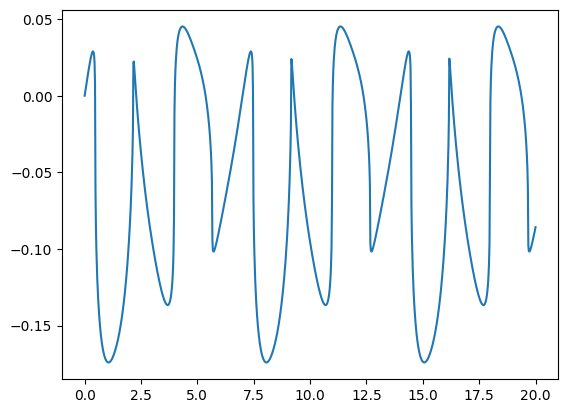

In [25]:
plt.plot(t, y1)

Get the actual times (this assumes 3 suns orbiting at earth-sun distance)

In [26]:
tt = 1/np.sqrt(6.67e-11 * 1.99e30 / (1.5e11)**3 ) # seconds
tt = tt / (60 * 60 * 24* 365.25) * np.diff(t)[0] # per time step (in years)

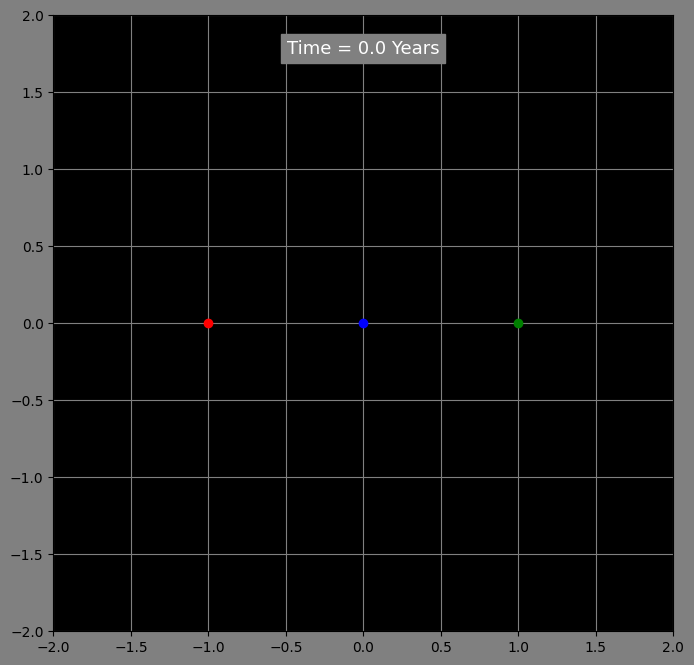

In [31]:
def animate(i):
    ln1.set_data([x1[i]], [y1[i]])
    ln2.set_data([x2[i]], [y2[i]])
    ln3.set_data([x3[i]], [y3[i]])
    text.set_text('Time = {:.1f} Years'.format(i*tt))
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.grid(color='grey')
ln1, = plt.plot([], [], 'ro', lw=3, markersize=6)
ln2, = plt.plot([], [], 'go', lw=3, markersize=6)
ln3, = plt.plot([], [], 'bo', lw=3, markersize=6)
text = plt.text(0, 1.75, 'asdasd', fontsize=13, backgroundcolor='grey', ha='center', color='white')
ax.set_ylim(-2, 2)
ax.set_xlim(-2,2)
fig.patch.set_facecolor('grey')
ax.set_facecolor('black')
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('Three_body_problem.gif',writer='pillow',fps=30)